# Desafío Python DS Ssr - Freelance

## 1. Objetivos

- Dataset de marketing de un banco portugues. 

- El objetivo es evaluar los datos, realizando un análisis descriptivo y evaluar una serie de modelos de clasificación y elegir el que mejor  resultados obtiene prediciendo la columna 21 que representa si se suscribe al servicio correspondiente (El objetivo de clasificación binaria es predecir si el cliente suscribirá un depósito a plazo bancario).

## Diccionario de datos

## Variables de entrada

### Datos del cliente bancario
1. **age**: edad (numérico)  
2. **job**: tipo de trabajo  
   *Categorías:* `"admin."`, `"blue-collar"`, `"entrepreneur"`, `"housemaid"`, `"management"`, `"retired"`, `"self-employed"`, `"services"`, `"student"`, `"technician"`, `"unemployed"`, `"unknown"`  
3. **marital**: estado civil  
   *Categorías:* `"divorced"`, `"married"`, `"single"`, `"unknown"`  
   > Nota: `"divorced"` incluye divorciado o viudo.  
4. **education**: nivel educativo  
   *Categorías:* `"basic.4y"`, `"basic.6y"`, `"basic.9y"`, `"high.school"`, `"illiterate"`, `"professional.course"`, `"university.degree"`, `"unknown"`  
5. **default**: ¿tiene crédito en mora?  
   *Categorías:* `"no"`, `"yes"`, `"unknown"`  
6. **housing**: ¿tiene préstamo hipotecario?  
   *Categorías:* `"no"`, `"yes"`, `"unknown"`  
7. **loan**: ¿tiene préstamo personal?  
   *Categorías:* `"no"`, `"yes"`, `"unknown"`  

### Relacionadas con el último contacto de la campaña actual
8. **contact**: tipo de comunicación  
   *Categorías:* `"cellular"`, `"telephone"`  
9. **month**: mes del último contacto  
   *Categorías:* `"jan"`, `"feb"`, `"mar"`, …, `"nov"`, `"dec"`  
10. **day_of_week**: día de la semana del último contacto  
    *Categorías:* `"mon"`, `"tue"`, `"wed"`, `"thu"`, `"fri"`  
11. **duration**: duración del último contacto, en segundos (numérico)  
    > **Nota importante:** este atributo influye fuertemente en el objetivo (por ejemplo, si `duration=0` entonces `y="no"`).  
    > Sin embargo, la duración no se conoce antes de realizar la llamada y, una vez finalizada, el resultado (`y`) ya es evidente.  
    > Por ello, **solo debe usarse con fines de benchmarking** y descartarse si se busca un modelo predictivo realista.

### Otros atributos
12. **campaign**: número de contactos realizados durante esta campaña para este cliente (numérico, incluye el último contacto)  
13. **pdays**: número de días transcurridos desde el último contacto en una campaña previa  
    > *Valor especial:* `999` significa que el cliente no fue contactado anteriormente.  
14. **previous**: número de contactos previos a esta campaña para este cliente (numérico)  
15. **poutcome**: resultado de la campaña de marketing anterior  
    *Categorías:* `"failure"`, `"nonexistent"`, `"success"`  

### Atributos de contexto social y económico
16. **emp.var.rate**: tasa de variación del empleo – indicador trimestral (numérico)  
17. **cons.price.idx**: índice de precios al consumidor – indicador mensual (numérico)  
18. **cons.conf.idx**: índice de confianza del consumidor – indicador mensual (numérico)  
19. **euribor3m**: tasa euríbor a 3 meses – indicador diario (numérico)  
20. **nr.employed**: número de empleados – indicador trimestral (numérico)  

---

## Variable de salida (objetivo)
21. **y**: ¿el cliente suscribió un depósito a plazo?  
    *Binaria:* `"yes"`, `"no"`


## 1. Import libraries

In [54]:
import re
import math
import pandas as pd
import numpy as np
import json
from pandas import json_normalize
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, average_precision_score
)
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier, callback as xgb_callback
from sklearn.utils.class_weight import compute_sample_weight
import lightgbm as lgb

## 2. Functions

In [2]:
def zero_variance_columns(df: pd.DataFrame, numeric_only: bool = True) -> list[str]:
    """
    Retorna las columnas con varianza cero.
    Criterio: nunique(dropna=True) <= 1  (todas las no nulas son iguales).
    - numeric_only=True: evalúa solo columnas numéricas.
    """
    cols = df.select_dtypes(include=np.number).columns if numeric_only else df.columns
    return [c for c in cols if df[c].nunique(dropna=True) <= 1]


def missing_pct_table(df: pd.DataFrame, gt: float = 0.0, decimals: int = 2) -> pd.DataFrame:
    """
    Devuelve una tabla con columnas cuyo % de nulos es > gt.
    - df: DataFrame de entrada (ej.: num_df).
    - gt: umbral estricto (por defecto, 0.0 → muestra > 0%).
    - decimals: decimales para redondeo del %.

    Retorna columnas: ['columna', 'n_faltantes', 'pct_faltantes'] ordenadas desc.
    """
    n = len(df)
    stats = pd.DataFrame({
        "columna": df.columns,
        "n_faltantes": df.isna().sum().values
    })
    stats["pct_faltantes"] = (stats["n_faltantes"] / n * 100).round(decimals)
    stats = stats[stats["pct_faltantes"] > gt]\
             .sort_values("pct_faltantes", ascending=False)\
             .reset_index(drop=True)
    return stats


def visualize_high_outlier_numeric(num_df: pd.DataFrame, threshold: float = 5.0, top: int | None = None, bins: int = 30) -> pd.DataFrame:
    """
    Pipeline: resume outliers, filtra por umbral y grafica hist+box para esas columnas.
    Retorna el subset del resumen para las columnas seleccionadas.
    """
    summary = summarize_outliers_iqr(num_df)
    cols = select_columns_by_outlier_pct(summary, threshold=threshold, top=top)
    plot_hist_and_box_side_by_side(num_df, cols, bins=bins)
    return summary[summary["columna"].isin(cols)][["columna", "pct_outliers", "n_outliers", "n"]]


def summarize_outliers_iqr(df: pd.DataFrame) -> pd.DataFrame:
    """Resumen de outliers por IQR para cada columna numérica del DF."""
    rows = []
    for c in df.columns:
        x = pd.to_numeric(df[c], errors="coerce").dropna().values
        if x.size == 0:
            continue
        q1 = np.percentile(x, 25)
        q3 = np.percentile(x, 75)
        iqr = q3 - q1
        if iqr == 0:
            lower, upper = q1, q3
        else:
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
        n_out = int(((x < lower) | (x > upper)).sum())
        n = int(x.size)
        rows.append({
            "columna": c,
            "n": n,
            "q1": q1, "q3": q3, "iqr": iqr,
            "lower_fence": lower, "upper_fence": upper,
            "n_outliers": n_out, "pct_outliers": round(100 * n_out / n, 2),
            "min": float(np.min(x)), "max": float(np.max(x)),
            "mean": float(np.mean(x)), "median": float(np.median(x)),
            "std": float(np.std(x, ddof=1)) if n > 1 else 0.0
        })
    return pd.DataFrame(rows).sort_values("pct_outliers", ascending=False).reset_index(drop=True)

    
def select_columns_by_outlier_pct(summary_df: pd.DataFrame, threshold: float, top: int | None = None) -> list[str]:
    """Columnas con % de outliers >= threshold (opcional: limitar a top N)."""
    sel = summary_df[summary_df["pct_outliers"] >= threshold].sort_values("pct_outliers", ascending=False)
    if top is not None:
        sel = sel.head(top)
    return sel["columna"].tolist()        


def plot_hist_and_box_side_by_side(df: pd.DataFrame, columns: list[str], bins: int = 30):
    """Para cada columna: histograma + boxplot horizontal, lado a lado."""
    for c in columns:
        x = pd.to_numeric(df[c], errors="coerce").dropna().values
        if x.size == 0:
            continue
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        # Histograma
        axes[0].hist(x, bins=bins)
        axes[0].set_title(f"Histograma - {c}")
        axes[0].set_xlabel(c)
        axes[0].set_ylabel("Frecuencia")
        # Boxplot horizontal
        axes[1].boxplot(x, vert=False, showfliers=True)
        axes[1].set_title(f"Boxplot - {c}")
        axes[1].set_xlabel(c)
        plt.tight_layout()
        plt.show()


def multicollinearity_candidates(df: pd.DataFrame, thr: float = 0.90, numeric_only: bool = True, verbose: bool = True):
    """
    Detecta pares con |correlación| >= thr y sugiere qué columna eliminar en cada caso.
    Regla simple: en cada par, se elimina la columna con mayor 'correlación media' con el resto
    (más redundante). No modifica el DataFrame original.

    Retorna:
      - cols_to_drop: lista de columnas sugeridas para eliminar
      - decisions:    lista de tuplas (col1, col2, corr_abs, drop, keep)
    """
    X = df.select_dtypes(include=np.number) if numeric_only else df
    # quitar constantes (no aportan y complican corr)
    X = X.loc[:, X.nunique(dropna=True) > 1]

    if X.shape[1] <= 1:
        if verbose:
            print("No hay suficientes columnas para evaluar correlación.")
        return [], []

    corr = X.corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

    # pares sobre el umbral
    pairs = [(i, j, float(upper.loc[i, j]))
             for i in upper.index for j in upper.columns
             if pd.notna(upper.loc[i, j]) and upper.loc[i, j] >= thr]

    if not pairs:
        if verbose:
            print(f"No se encontraron pares con |r| >= {thr}.")
        return [], []

    # correlación media (sin diagonal=1.0)
    meanc = corr.replace(1.0, np.nan).mean()

    cols_to_drop, decisions = set(), []
    # procesar del par más correlacionado al menos
    for a, b, r in sorted(pairs, key=lambda t: t[2], reverse=True):
        if a in cols_to_drop or b in cols_to_drop:
            continue
        # descartar la más redundante (mayor correlación media); si empatan, descartar la de menor varianza
        if meanc[a] > meanc[b]:
            drop, keep = a, b
        elif meanc[b] > meanc[a]:
            drop, keep = b, a
        else:
            var = X.var(ddof=1)
            drop, keep = (a, b) if var[a] < var[b] else (b, a)
        cols_to_drop.add(drop)
        decisions.append((a, b, r, drop, keep))
        if verbose:
            print(f"({a}, {b}) |r|={r:.3f} -> drop column: {drop}, keep column: {keep}")

    return sorted(cols_to_drop), decisions


def corr_heatmap_lower_triangle_with_target_last(clients_df: pd.DataFrame, target_col: str = "y"):
    """
    Calcula la matriz de correlación (Pearson), asegura que el target sea numérico 0/1,
    reordena las columnas dejando el target al final y grafica solo la mitad inferior
    (incluida la diagonal) del heatmap.
    """
    df = clients_df.copy()

    # --- Asegurar target numérico 0/1 ---
    if df[target_col].dtype == bool:
        df[target_col] = df[target_col].astype(int)
    elif df[target_col].dtype == object:
        mapping = {"yes": 1, "no": 0, "YES": 1, "NO": 0, True: 1, False: 0}
        df[target_col] = df[target_col].map(mapping)
    df[target_col] = pd.to_numeric(df[target_col], errors="coerce")

    # Solo numéricas
    num_df = df.select_dtypes(include=[np.number]).copy()
    if target_col not in num_df.columns:
        raise ValueError(f"El target '{target_col}' no quedó como numérico; no entra en la correlación.")

    # Target al final
    cols = [c for c in num_df.columns if c != target_col] + [target_col]
    num_df = num_df[cols]

    # Matriz de correlación
    corr_matrix = num_df.corr(method="pearson")

    # ---- Heatmap de mitad inferior ----
    vals = corr_matrix.values
    # máscara de triángulo superior (sin diagonal)
    mask_upper = np.triu(np.ones_like(vals, dtype=bool), k=1)
    # enmascarar triángulo superior para que no se pinte
    corr_masked = np.ma.masked_where(mask_upper, vals)

    plt.figure(figsize=(8, 6))
    # Limitar escala a [-1, 1] para consistencia
    im = plt.imshow(corr_masked, interpolation="nearest", cmap="coolwarm", vmin=-1, vmax=1)
    plt.colorbar(im, label="Pearson r")
    plt.xticks(range(len(cols)), cols, rotation=90)
    plt.yticks(range(len(cols)), cols)
    plt.title("Matriz de correlación")
    plt.tight_layout()
    plt.show()

    return None


def select_by_target_corr(
    df: pd.DataFrame,
    target_col: str = "target",
    abs_threshold: float = 0.2,
    method: str = "pearson",
    numeric_only: bool = True,
    exclude: list[str] | None = None,
    return_table: bool = False,
):
    """
    Devuelve las columnas cuyo |correlación(feature, target)| >= abs_threshold.
    - abs_threshold ∈ [0,1] (p.ej., 0.2 ≈ 20% del máximo posible).
    - method: 'pearson' o 'spearman'.
    - numeric_only=True: solo evalúa columnas numéricas.
    - exclude: lista de columnas a ignorar.
    - return_table=True: además retorna un DataFrame con corr y |corr|.
    
    Retorna:
      - selected (list[str])  [y opcionalmente corr_df si return_table=True]
    """
    if target_col not in df.columns:
        raise ValueError(f"'{target_col}' no está en el DataFrame.")

    y = pd.to_numeric(df[target_col], errors="coerce")
    if y.nunique(dropna=True) <= 1:
        raise ValueError("El target no tiene variabilidad suficiente.")

    cols = df.select_dtypes(include=np.number).columns.tolist() if numeric_only else df.columns.tolist()
    if exclude:
        cols = [c for c in cols if c not in set(exclude)]
    cols = [c for c in cols if c != target_col]

    corrs = []
    for c in cols:
        s = pd.to_numeric(df[c], errors="coerce")
        if s.nunique(dropna=True) <= 1:
            continue  # sin variación, correlación no informativa
        r = s.corr(y, method=method)
        corrs.append((c, r))

    corr_df = pd.DataFrame(corrs, columns=["feature", "corr"]).dropna()
    corr_df["abs_corr"] = corr_df["corr"].abs()
    corr_df = corr_df.sort_values("abs_corr", ascending=False).reset_index(drop=True)

    selected = corr_df.loc[corr_df["abs_corr"] >= abs_threshold, "feature"].tolist()
    return (selected, corr_df) if return_table else selected


def columnas_por_tipo(
    df: pd.DataFrame,
    incluir_category: bool = True,
    detect_bool_numeric: bool = True,
    detect_bool_strings: bool = True,
) -> dict[str, list[str]]:
    """
    Devuelve columnas por tipo:
      - 'categorical': dtype object (y 'category' si incluir_category=True) EXCLUYENDO las que son booleanos tipo texto (Sí/No, True/False, etc.)
      - 'numeric'    : columnas numéricas (excluye bool nativo y binarios 0/1 si detect_bool_numeric=True)
      - 'boolean'    : bool nativo + binarios 0/1 + textos mapeables a booleano (si detect_* están activos)
      - 'dates'      : columnas datetime64 (cualquier tz)
    """

    # 1) bases por dtype
    inc = ["object"] + (["category"] if incluir_category else [])
    cat_cols  = df.select_dtypes(include=inc).columns.tolist()
    bool_cols = df.select_dtypes(include=["bool"]).columns.tolist()
    date_cols = [c for c in df.columns if pd.api.types.is_datetime64_any_dtype(df[c])]
    num_cols  = [c for c in df.select_dtypes(include=["number"]).columns if c not in bool_cols]

    # 2) detectar booleanos numéricos binarios (0/1) y moverlos de numeric -> boolean
    if detect_bool_numeric:
        bin_num_cols = []
        for c in num_cols:
            s = pd.to_numeric(df[c], errors="coerce")
            u = set(pd.unique(s.dropna()))
            if len(u) <= 2 and u.issubset({0, 1}):
                bin_num_cols.append(c)
        # mover
        bool_cols.extend(bin_num_cols)
        num_cols = [c for c in num_cols if c not in bin_num_cols]

    # 3) detectar booleanos en texto/categoría (Sí/No, True/False, etc.) y moverlos de categorical -> boolean
    if detect_bool_strings and cat_cols:
        true_vals  = {"true","t","si","sí","s","y","yes","1","verdadero"}
        false_vals = {"false","f","no","n","0","falso"}

        def _norm(x):
            return str(x).strip().lower()

        text_bool_cols = []
        for c in cat_cols:
            u = pd.Series(df[c].dropna().unique()).map(_norm)
            if len(u) <= 2 and set(u).issubset(true_vals.union(false_vals)):
                text_bool_cols.append(c)

        # mover
        bool_cols.extend(text_bool_cols)
        cat_cols = [c for c in cat_cols if c not in text_bool_cols]

    # 4) quitar cualquier date col de otras listas por seguridad
    cat_cols = [c for c in cat_cols if c not in date_cols]
    num_cols = [c for c in num_cols if c not in date_cols]
    bool_cols = sorted(set(bool_cols))
    cat_cols  = sorted(set(cat_cols))
    num_cols  = sorted(set(num_cols))
    date_cols = sorted(set(date_cols))

    return {
        "categorical": cat_cols,
        "numeric": num_cols,
        "boolean": bool_cols,
        "dates": date_cols,
    }


def plot_cat_target_share_grouped(df, target="y", include_missing=True, max_levels=10, title_pad=18):
    """
    Barras lado a lado con % de target=0/1 por categoría.
    """
    # Solo categóricas puras (object/category), sin booleanas
    cats = df.select_dtypes(include=["object", "category"]).columns.tolist()
    cats = [c for c in cats if c != target]

    y = pd.to_numeric(df[target], errors="coerce")

    for col in cats:
        s = df[col]
        if include_missing:
            s = s.fillna("Missing")

        # Limitar a top categorías por frecuencia
        keep = s.value_counts().head(max_levels).index
        m = y.isin([0, 1]) & s.isin(keep)
        if m.sum() == 0:
            continue

        # % de target por categoría (filas suman 100%)
        tab = (pd.crosstab(s[m], y[m], normalize="index") * 100).reindex(keep)
        tab = tab.reindex(columns=[0, 1], fill_value=0)

        # Barras lado a lado
        idx = np.arange(len(tab))
        width = 0.4

        fig, ax = plt.subplots(figsize=(max(6, 0.6*len(tab)), 4), constrained_layout=True)
        ax.bar(idx - width/2, tab[0].values, width, label="target=0")
        ax.bar(idx + width/2, tab[1].values, width, label="target=1")

        ax.set_xticks(idx)
        ax.set_xticklabels(tab.index.astype(str), rotation=45, ha="right")
        ax.set_ylim(0, 100)
        ax.set_ylabel("Porcentaje (%)")
        ax.set_xlabel(col)
        ax.set_title(f"{col} — % de target por categoría", pad=title_pad)
        ax.legend()

        # Etiquetas (opcionales)
        for x, v in zip(idx - width/2, tab[0].values):
            if v > 3: ax.text(x, v + 1, f"{v:.0f}%", ha="center", va="bottom")
        for x, v in zip(idx + width/2, tab[1].values):
            if v > 3: ax.text(x, v + 1, f"{v:.0f}%", ha="center", va="bottom")

        plt.show()


def one_hot_clean(
    df: pd.DataFrame,
    include_missing: bool = True,
    drop_first: bool = True,
    max_levels: int | None = None,
    prefix_sep: str = "=",
) -> pd.DataFrame:
    """
    Convierte columnas categóricas (object/category) a dummies:
      - drop_first=True deja matriz full-rank (evita el 'dummy trap').
      - include_missing=True trata NaN como categoría 'Missing'.
      - max_levels: si se define, agrupa categorías poco frecuentes en 'Other'
        quedándose con las 'max_levels' más frecuentes antes del one-hot.
      - Elimina columnas constantes (todo 0/1) tras el encoding.
    """
    g = df.copy()
    cats = g.select_dtypes(include=["object", "category"]).columns.tolist()
    if not cats:
        return g

    # Agrupar categorías raras si se pidió
    if max_levels is not None:
        for c in cats:
            s = g[c]
            if include_missing:
                s = s.fillna("Missing")
            top = s.value_counts(dropna=False).nlargest(max_levels).index
            g[c] = np.where(s.isin(top), s, "Other")
    elif include_missing:
        g[cats] = g[cats].fillna("Missing")

    # One-hot (full-rank por variable si drop_first=True)
    dummies = pd.get_dummies(
        g[cats], drop_first=drop_first, dummy_na=False, prefix_sep=prefix_sep
    )
    out = pd.concat([g.drop(columns=cats), dummies], axis=1)

    # Eliminar columnas constantes (redundantes)
    const_cols = [c for c in out.columns if out[c].nunique(dropna=False) <= 1]
    if const_cols:
        out = out.drop(columns=const_cols)

    return out


def bools_to_int01(clients_df: pd.DataFrame, dtype="Int8") -> pd.DataFrame:
    """
    Convierte todas las columnas booleanas (bool / boolean) a 0/1.
    Mantiene los NA usando enteros 'nullable' (Int8/Int16/Int32).
    """
    out = clients_df.copy()
    bool_cols = out.select_dtypes(include=["bool", "boolean"]).columns

    for c in bool_cols:
        # aseguro dtype booleano 'nullable' para conservar NA
        out[c] = out[c].astype("boolean")
        # paso a entero 0/1 manteniendo NA
        out[c] = out[c].astype(dtype)

    return out


def stratified_split(df: pd.DataFrame, target="target", test_size=0.2, random_state=42):
    # asegurar target binario y sin NaN
    y = pd.to_numeric(df[target], errors="coerce")
    m = y.isin([0, 1])
    df = df.loc[m].reset_index(drop=True)
    y = df[target].astype(int)

    train_df, test_df = train_test_split(
        df, test_size=test_size, stratify=y, random_state=random_state
    )
    return train_df, test_df


def oversample_to_shares(
    train_df: pd.DataFrame,
    target: str = "target",
    minority_label: int = 1,
    minority_share: float = 0.40,
    majority_share: float = 0.60,
    random_state: int = 42,
):
    """
    Oversampling SOLO en train_df para alcanzar approximately:
      - minority_share del total en la clase `minority_label`
      - majority_share del total en la clase opuesta (complemento)
    Requiere imblearn. Devuelve (train_balanceado, sampler).

    Notas:
    - Solo duplica filas de la clase minoritaria (no toca la mayoritaria).
    - Si ya superás el share objetivo, no puede "reducir": retorna el df tal cual.
    """
    if target not in train_df.columns:
        raise KeyError(f"Columna '{target}' no encontrada en train_df.")
    # validar porcentajes
    if not (0 < minority_share < 1) or not (0 < majority_share < 1):
        raise ValueError("Los shares deben estar entre 0 y 1.")
    if abs(minority_share + majority_share - 1.0) > 1e-6:
        raise ValueError("minority_share + majority_share debe sumar 1.")

    df = train_df.copy()
    y = pd.to_numeric(df[target], errors="coerce")
    df = df.loc[y.isin([0, 1])].reset_index(drop=True)
    y = df[target].astype(int)

    # conteos actuales
    vc = y.value_counts()
    if set(vc.index) != {0, 1}:
        raise ValueError("El target debe ser binario con clases 0 y 1.")

    maj_label = 1 - minority_label
    n_min, n_maj = int(vc.get(minority_label, 0)), int(vc.get(maj_label, 0))
    if n_min == 0 or n_maj == 0:
        raise ValueError("No es posible oversampling si falta alguna clase en train.")

    # objetivo: n_min_target = (minority_share / majority_share) * n_maj
    ratio = minority_share / majority_share
    n_min_target = int(np.ceil(ratio * n_maj))
    if n_min_target <= n_min:
        # ya estás por encima del objetivo; no se puede des-muestrear aquí
        return df, None

    # usar estrategia dict para forzar exactamente el recuento de la clase minoritaria
    sampling_strategy = {minority_label: n_min_target}

    X = df.drop(columns=[target])
    ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=random_state)
    X_res, y_res = ros.fit_resample(X, y)

    df_res = pd.concat(
        [pd.DataFrame(X_res, columns=X.columns), pd.Series(y_res, name=target)],
        axis=1
    ).reset_index(drop=True)
    return df_res, ros


## 3. Read Data

In [3]:
file_path = "data/bank-additional-full (2)_1.csv"

clients_df = pd.read_csv(file_path, sep=";")

print(clients_df.shape)
clients_df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


**Distribución de la variable target (%)**

y
no     36548
yes     4640
Name: count, dtype: int64


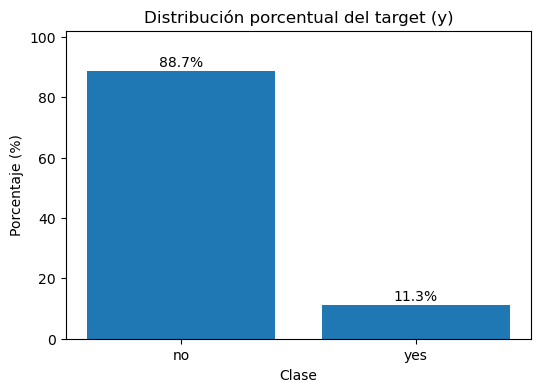

In [4]:
# Compute percentage distribution
pct = (clients_df["y"].value_counts(normalize=True) * 100).sort_index()
print(clients_df["y"].value_counts())  # distribución del target

# Plot
plt.figure(figsize=(6,4))
plt.bar(pct.index.astype(str), pct.values)
plt.title("Distribución porcentual del target (y)")
plt.ylabel("Porcentaje (%)")
plt.xlabel("Clase")
# Annotate bars
for x, v in zip(pct.index.astype(str), pct.values):
    plt.text(x, v + 0.5, f"{v:.1f}%", ha="center", va="bottom")
plt.ylim(0, max(pct.values) * 1.15)
plt.show()


**Insights**
- El dataset consiste en 41188 registros, con 21 features y un target (y) booleano que define si un cliente se suscribió a un depósito a plazo (target=yes), o no (target=no).
- El dataset se encuentra desbalanceado, donde la clase minoritaria es la de que el cliente si se suscribió a un depósito a plazo (target=yes). Por lo cual trabajaremos más adelante una técnica de balanceo de clases, para aumentar la clase minoritaria.

## 4. Univariate analysis

Eliminamos la columna "duration", ya que la duración no se conoce antes de realizar la llamada y, una vez finalizada, el resultado ("y") ya es evidente.


In [5]:
clients_df.drop(columns=['duration'], inplace=True)

### 4.1 Eliminar columnas con varianza cero

Estas variables no aportan información al modelo por ser constantes.

In [6]:
cols_var0_all = zero_variance_columns(clients_df, numeric_only=False)
cols_var0_all

[]

**Insights**
- El dataset no cuenta con variables que tenga varianza cero.

### 4.2 Analizamos los nulos

In [7]:
# Nulos
missing_gt0_num = missing_pct_table(clients_df, gt=0.0)
missing_gt0_num.rename(columns={'n_faltantes':'# faltantes','pct_faltantes':'% faltantes'},inplace=True)
missing_gt0_num

,columna,# faltantes,% faltantes


**Insights**
- El dataset no cuenta con valors nullos pero hay varios valores faltantes en algunos atributos categóricos, todos codificados con la etiqueta "unknown".
- Estos valores faltantes pueden tratarse como una posible etiqueta de clase o mediante técnicas de eliminación o imputación, analizaremos cada caso más adelante.

### 4.3 Analizamos las variables numéricas, outliers y sus distribuciones.

In [8]:
clients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  campaign        41188 non-null  int64  
 11  pdays           41188 non-null  int64  
 12  previous        41188 non-null  int64  
 13  poutcome        41188 non-null  object 
 14  emp.var.rate    41188 non-null  float64
 15  cons.price.idx  41188 non-null  float64
 16  cons.conf.idx   41188 non-null  float64
 17  euribor3m       41188 non-null 

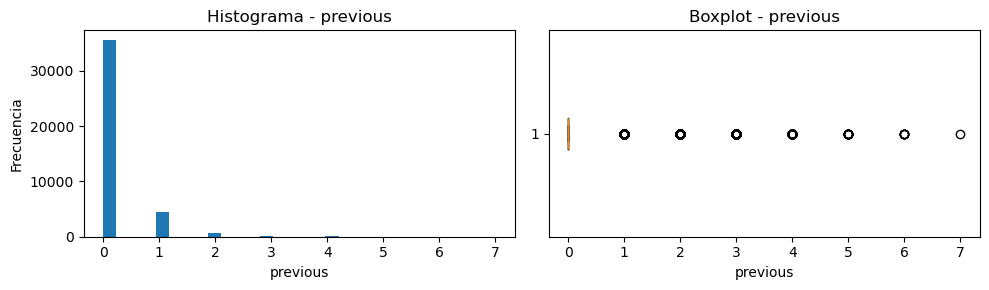

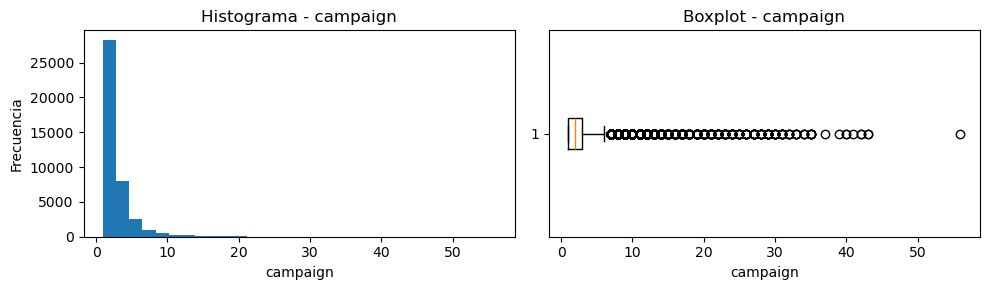

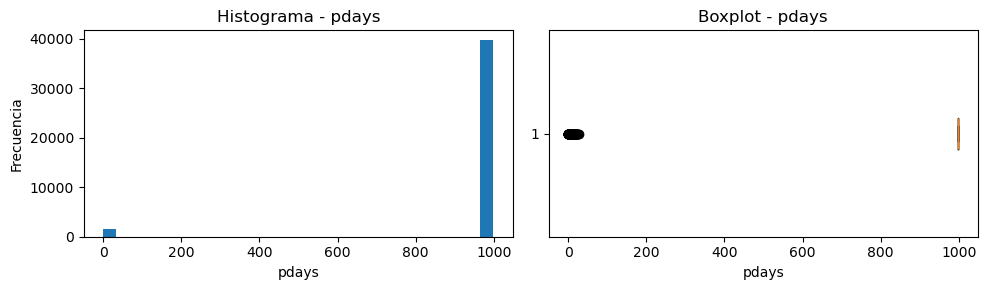

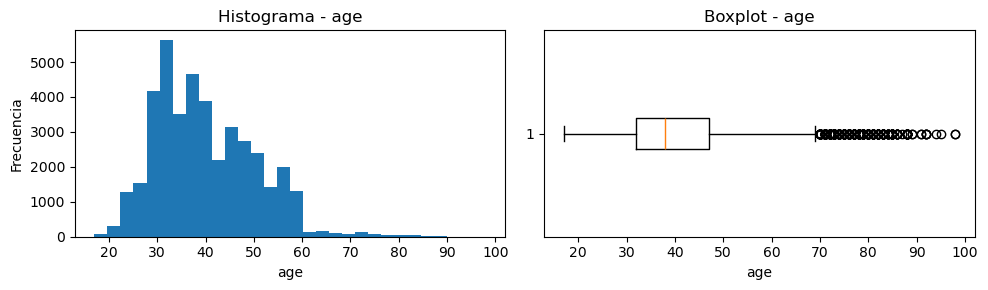

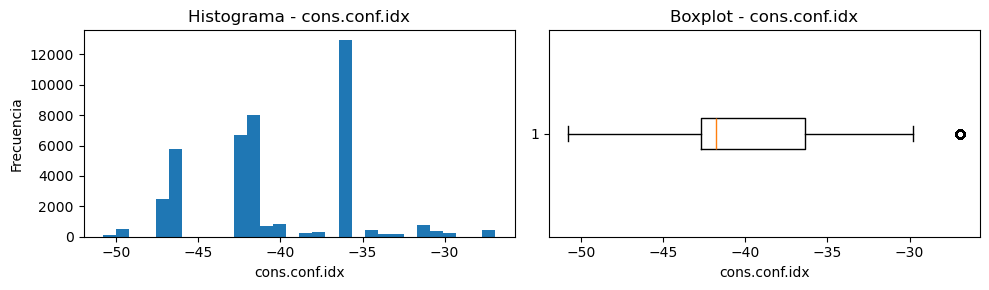

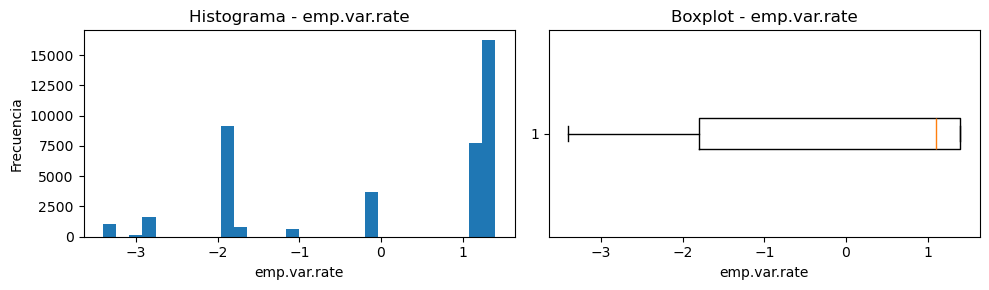

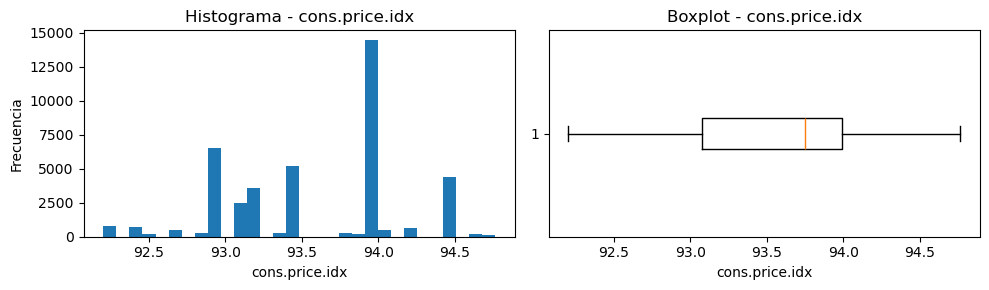

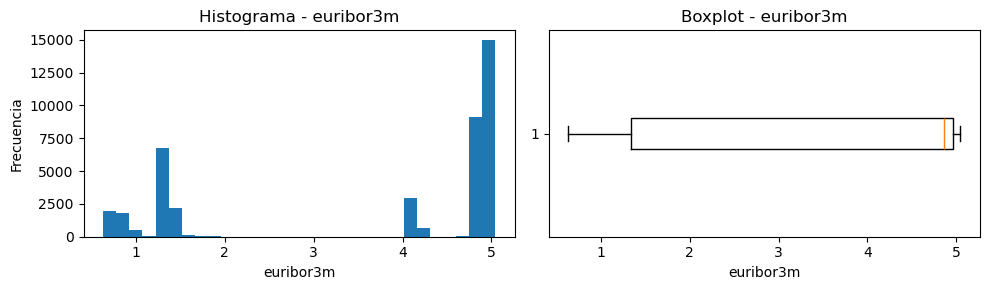

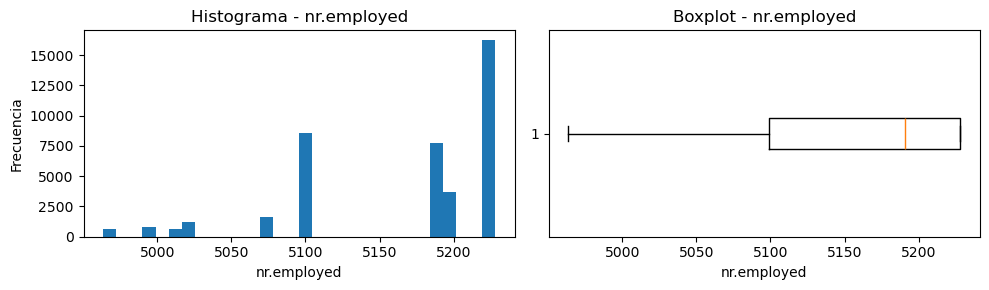

,columna,pct_outliers,n_outliers,n
0,previous,13.66,5625,41188
1,campaign,5.84,2406,41188
2,pdays,3.68,1515,41188
3,age,1.14,469,41188
4,cons.conf.idx,1.09,447,41188
5,emp.var.rate,0.00,0,41188
6,cons.price.idx,0.00,0,41188
7,euribor3m,0.00,0,41188
8,nr.employed,0.00,0,41188


In [9]:
# Muestra las variables con % de outliers >= threshold
# Grafica las Top-20 columnas con más outliers
num_df=clients_df
res_sel = visualize_high_outlier_numeric(num_df, threshold=0.0, top=20, bins=30)
res_sel

**Insights**
- **previous**: La gran mayoría de los registros tiene previous = 0. Esto significa que la mayoría de los clientes no había sido contactado antes de la campaña actual. El resto de los valores (1, 2, … 7) no son errores de medición, sino clientes que efectivamente recibieron varios contactos. Por lo tanto, son outliers solo en el sentido estadístico, pero pueden ser información valiosa para el modelo, por lo cual no liminaremos esos outliers.
- **campaign**: La mayoría de los clientes recibió muy pocos contactos en la campaña actual, principalmente entre 1 y 3. El boxplot revela numerosos puntos fuera del rango intercuartil, incluso casos con 20, 30, 40 y hasta más de 50 contactos. 
Estos valores altos son outliers en sentido estadístico, pero representan campañas muy insistentes, por lo cual no liminaremos esos outliers.
- **pdays**: está altamente sesgada con un gran pico en 999. Este valor no es un error, sino un indicador especial que debe tratarse como categoría más que como dato continuo. Crearemos una variable binaria “contactado_previamente” (True si pdays ≠ 999, False en caso contrario).
- **age**: La mayor parte de los clientes se encuentra entre 30 y 50 años, con un pico claro alrededor de 35 años. El boxplot muestra varios puntos por encima de ~70 años, considerados outliers estadísticos. Sin embargo, no son errores, sino clientes de mayor edad que forman un grupo minoritario, por lo cual no liminaremos esos outliers.
- **cons.conf.idx**: este indicador de confianza del consumidor (mensual) tiene un rango aproximadamente entre -51 y -26. El boxplot muestra un pequeño grupo de puntos a la derecha (alrededor de -26/-27), que aparecen como outliers por estar bastante alejados del resto. Estos valores no parecen errores, sino meses en los que la confianza del consumidor fue comparativamente alta, por lo cual no liminaremos esos outliers.
- **emp.var.rate**: la tasa de variación del empleo (indicador trimestral), tiene un rango de valores de aproximadamente de -3.5 a +1.5. Y una distribución multimodal ya que se observan varios picos en torno a valores específicos (por ejemplo, cerca de -2, 0, y 1). Los valores por debajo de ~-3 aparecen como outliers estadísticos, pero no son errores, representan trimestres de fuerte caída en el empleo. Por lo cual no liminaremos esos outliers.
- **cons.price.idx:**: el índice de precios al consumidor (indicador mensual de inflación), tiene un rango de valores aproximadamente entre 92.0 y 94.7. El boxplot muestra una dispersión relativamente estrecha y no evidencia outliers extremos. Los valores más bajos (cercanos a 92.0) podrían marcarse como atípicos en términos estadísticos, pero no son errores: representan meses con un índice de precios más bajo.
- **euribor3m:**: la tasa Euríbor a 3 meses (indicador diario del mercado interbancario europeo), toma un rango de valores aproximadamente entre 0.6 y 5.0. La mayor concentración se da en los valores altos (4–5). El boxplot muestra una caja relativamente ancha y sin valores extremos marcados fuera de los bigotes. Aunque hay una amplia dispersión, los valores bajos (cerca de 0.6) no son errores, sino periodos de tasas muy reducidas.
- **nr.employed**: éste indicador económico del número de empleados (trimestral), presenta un rango de valores aproximadamente entre 4990 y 5230. La mayoría de las observaciones se concentran cerca de 5200, señal de que en gran parte del periodo analizado la economía mantuvo ese nivel de empleo. Los valores más bajos (cercanos a 4990) aparecen como outliers estadísticos, pero no son errores, representan trimestres en los que el empleo total del país era menor.

**Creación de la variable "contactado_previamente" en base a "pdays"**

In [10]:
# 1. Crear variable binaria: 1 si fue contactado antes, 0 si nunca (pdays == 999)
clients_df["contactado_previamente"] = (clients_df["pdays"] != 999).astype(int)

# 2. (Opcional) Verifica
#print(clients_df[["pdays", "contactado_previamente"]].value_counts())
print(clients_df["contactado_previamente"].value_counts())
#clients_df.drop(columns=['pdays'], inplace=True)

contactado_previamente
0    39673
1     1515
Name: count, dtype: int64


- Rellenar los nulos con un valor fijo fuera del rango real (por ejemplo -1).
- Crear una columna extra dias_missing = 1 si imputaste, 0 en caso contrario. Así el modelo sabe que “-1” no significa realmente “-1 días”, sino “no contactado”.

In [11]:
# Días reales solo para quienes sí fueron contactados; NaN si 999 (nunca fue contactado)
clients_df["dias_desde_ultimo_contacto"] = np.where(clients_df["pdays"] == 999, np.nan, clients_df["pdays"])

# Indicador de missing por imputación futura
clients_df["dias_missing"] = clients_df["dias_desde_ultimo_contacto"].isna().astype(int)

#Eliminamos la columna "pdays"
clients_df.drop(columns=['pdays'], inplace=True)

clients_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,contactado_previamente,dias_desde_ultimo_contacto,dias_missing
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,NaN,1
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,NaN,1
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,NaN,1
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,NaN,1
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no,0,NaN,1


- Si bien hemos introducido NaNs, no hemos perdido información.
- Utilizaremos entonces modelos de árboles modernos (XGBoost, LightGBM, CatBoost, scikit-learn HistGradientBoosting) que manejan NaN de forma nativa.
- Ventaja: no introduces valores artificiales y el modelo puede aprender “falta de dato = no contactado recientemente”.
- Escalaremos las variables numéricas más adelante, tanto en el conjunto de train como de test.

## 5. Multivariate analysis

### 5.1 Delete multicollinearity variables

In [12]:
# Detecta pares con |correlación| >= thr y sugiere qué columna eliminar en cada caso.
# Regla simple: en cada par, se elimina la columna con mayor 'correlación media' con el resto (más redundante).
cols_to_drop, detalle = multicollinearity_candidates(clients_df, thr=0.90, numeric_only=True, verbose=True)
print("\nColumnas sugeridas para eliminar:", cols_to_drop)

(contactado_previamente, dias_missing) |r|=1.000 -> drop column: contactado_previamente, keep column: dias_missing
(emp.var.rate, euribor3m) |r|=0.972 -> drop column: euribor3m, keep column: emp.var.rate
(emp.var.rate, nr.employed) |r|=0.907 -> drop column: emp.var.rate, keep column: nr.employed

Columnas sugeridas para eliminar: ['contactado_previamente', 'emp.var.rate', 'euribor3m']


In [13]:
clients_df2 = clients_df.drop(columns=cols_to_drop)
clients_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         41188 non-null  int64  
 1   job                         41188 non-null  object 
 2   marital                     41188 non-null  object 
 3   education                   41188 non-null  object 
 4   default                     41188 non-null  object 
 5   housing                     41188 non-null  object 
 6   loan                        41188 non-null  object 
 7   contact                     41188 non-null  object 
 8   month                       41188 non-null  object 
 9   day_of_week                 41188 non-null  object 
 10  campaign                    41188 non-null  int64  
 11  previous                    41188 non-null  int64  
 12  poutcome                    41188 non-null  object 
 13  cons.price.idx              411

### 5.2 Correlation of numerical characteristics vs. the target

In [14]:
# Mover el target 'y' al final
if "y" not in clients_df2.columns:
    raise KeyError("La columna 'y' no existe en clients_df2.")

cols = [c for c in clients_df2.columns if c != "y"] + ["y"]
clients_df2 = clients_df2[cols]

In [15]:
# Convertir el target "y" a binaria
map_y = {"yes": 1, "no": 0}
clients_df2["y"] = clients_df2["y"].map(map_y).astype("Int64")

In [16]:
clients_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         41188 non-null  int64  
 1   job                         41188 non-null  object 
 2   marital                     41188 non-null  object 
 3   education                   41188 non-null  object 
 4   default                     41188 non-null  object 
 5   housing                     41188 non-null  object 
 6   loan                        41188 non-null  object 
 7   contact                     41188 non-null  object 
 8   month                       41188 non-null  object 
 9   day_of_week                 41188 non-null  object 
 10  campaign                    41188 non-null  int64  
 11  previous                    41188 non-null  int64  
 12  poutcome                    41188 non-null  object 
 13  cons.price.idx              411

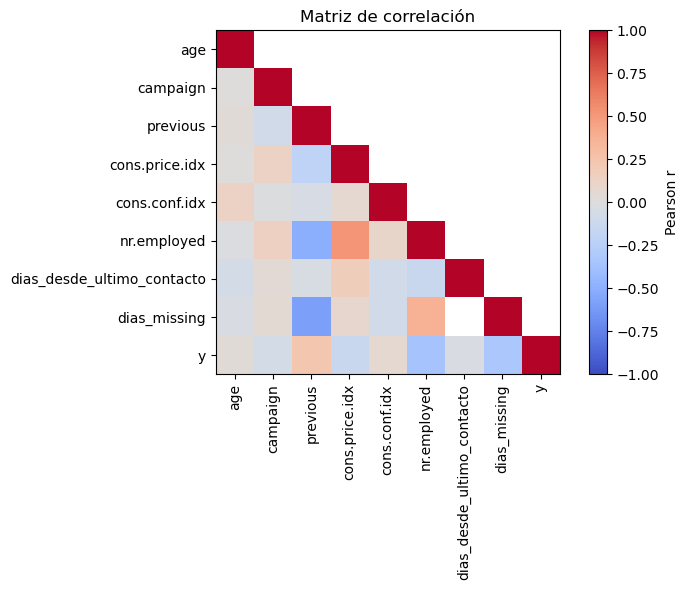

In [17]:
corr_heatmap_lower_triangle_with_target_last(clients_df2, target_col="y")

In [18]:
# Seleccionamos las variables con un umbral de correlación con el target > 0.2
cols_fuertes, tabla = select_by_target_corr(
    clients_df2, target_col="y", abs_threshold=0.2, method="pearson",
    numeric_only=True, exclude=None, return_table=True
)
print("Columnas seleccionadas:", cols_fuertes)
tabla.head(15)

Columnas seleccionadas: ['nr.employed', 'dias_missing', 'previous']


,feature,corr,abs_corr
0,nr.employed,-0.354678,0.354678
1,dias_missing,-0.324877,0.324877
2,previous,0.230181,0.230181
3,cons.price.idx,-0.136211,0.136211
4,campaign,-0.066357,0.066357
5,cons.conf.idx,0.054878,0.054878
6,dias_desde_ultimo_contacto,-0.035223,0.035223
7,age,0.030399,0.030399


- Ninguna variable tiene una correlación lineal fuerte con y.
- Las variables con mayor correlación con el target son:
    - `nr.employed`: A mayor número de empleados en la economía, menor probabilidad de que el cliente contrate un depósito a plazo (los depósitos a plazo se vuelven más atractivos en contextos de incertidumbre o recesión, cuando el empleo y la actividad económica son bajos y las tasas de interés más altas),
    - `dias_missing`: Cuando falta el dato de días desde el último contacto (es decir, el cliente nunca fue contactado antes), disminuye la probabilidad de éxito, 
    - `previous`: Haber tenido contactos previos aumenta la probabilidad de suscripción
- Si bien existen correlaciones bajas, decidimos en ésta instancia dejar todas las variables numéricas y utilizar modelos que puedan decidir su feature importance (Random Forest, XGBoost, LightGBM, etc.). Estos algoritmos capturan interacciones y relaciones no lineales incluso cuando la correlación de Pearson es baja.

### 5.3 Analysis of categorical variables with respect to the target

In [19]:
tipos = columnas_por_tipo(clients_df2)
tipos["categorical"]

['contact',
 'day_of_week',
 'default',
 'education',
 'housing',
 'job',
 'loan',
 'marital',
 'month',
 'poutcome']

**Tenemos algunas variables categóricas: veamos su relación con respecto al target.**

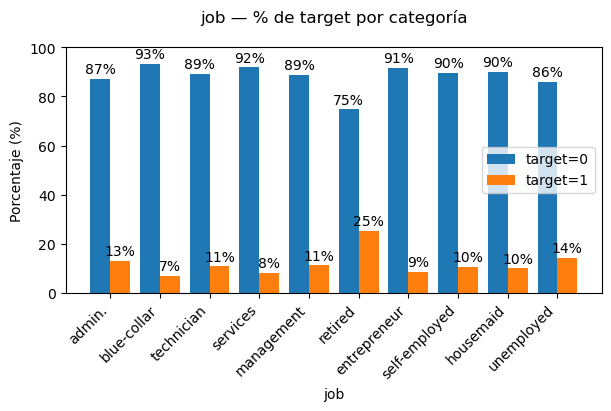

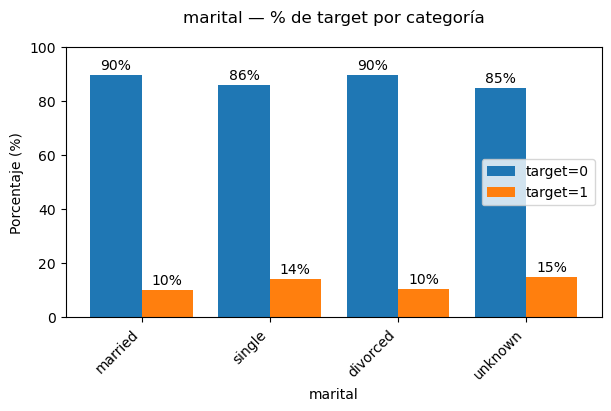

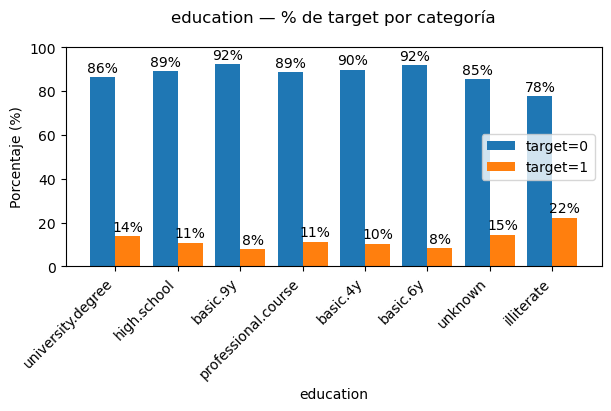

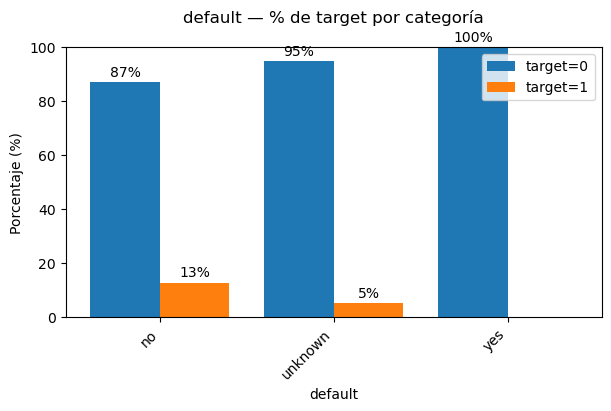

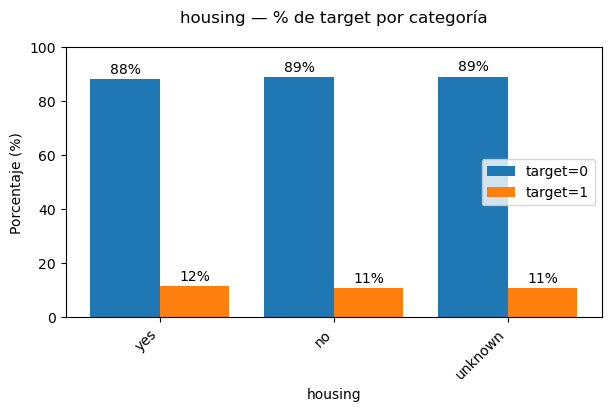

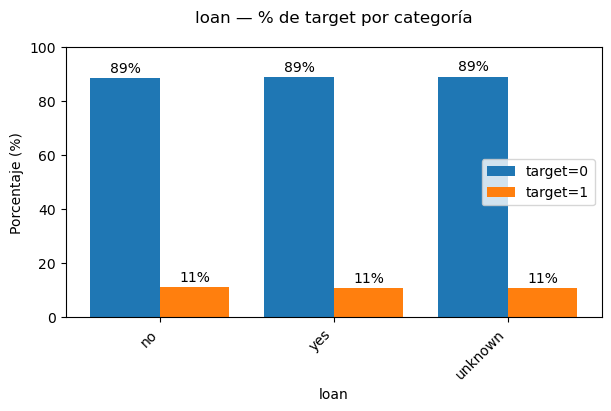

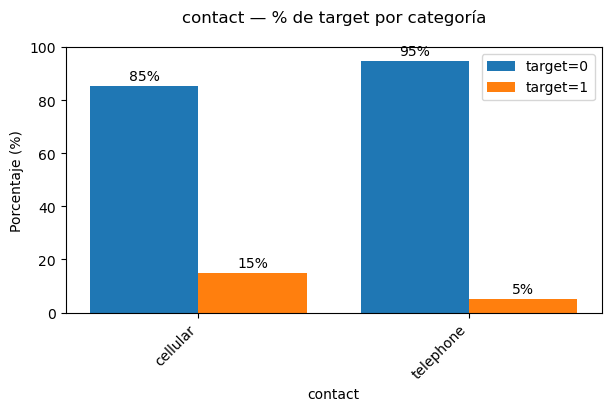

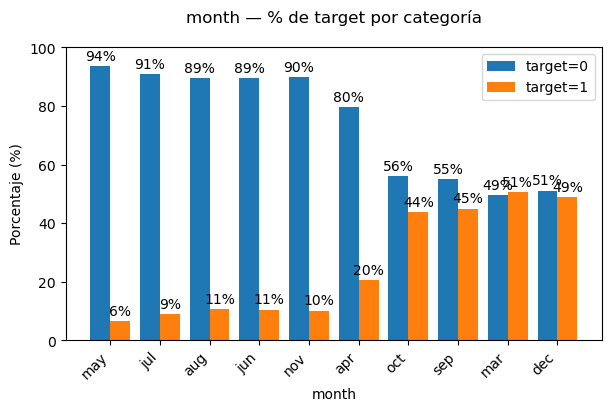

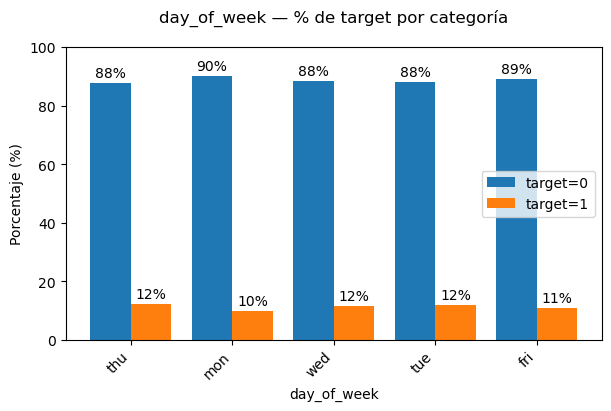

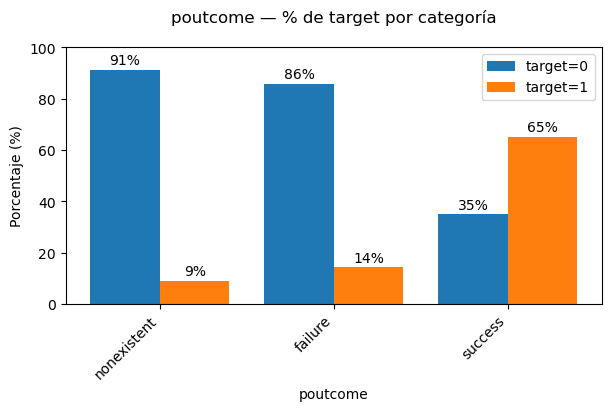

In [20]:
plot_cat_target_share_grouped(clients_df2)

**Insights**
- **Job**: El perfil de mayor respuesta son los jubilados, seguidos a distancia por los desempleados, mientras que blue-collar es el grupo con menor propensión a contratar un depósito a plazo. => Dejar la variable.
- **Marital**: El estado civil influye ligeramente en la probabilidad de suscripción. "Single" y "unknown" son más propensos a contratar. "Married" y "divorced" tienen menor propensión. => Dejar la variable.
- **Education**: El nivel educativo es un factor diferenciador. "Illiterate", "unknown" y "university.degree" tienen mayor probabilidad de contratar un depósito a plazo. "Educación básica" o "profesional" tienen menor probabilidad. => Dejar la variable.
- **Default**: La variable default es altamente relevante para predecir la suscripción a un depósito a plazo. Clientes sin mora (no) → más probabilidad de éxito (13 %). Clientes con mora (yes) → nula probabilidad de éxito.  => Dejar la variable.
- **Housing**: Prácticamente no hay diferencia en la probabilidad de contratar un depósito a plazo entre quienes tienen o no hipoteca. Se puede dejar la variable, pero tendrá poca influencia. => Eliminar la variable.
- **Loan**: La variable muestra ninguna diferencia en la tasa de conversión, independientemente de si el cliente tiene o no un préstamo personal.  => Eliminar la variable.
- **Contact**: El tipo de contacto es determinante: contactar al cliente por celular triplica la tasa de éxito en comparación con llamadas a teléfono fijo. => Dejar la variable.
- **Month**: Efecto estacional claro: el mes en que se realiza la campaña influye fuertemente en la probabilidad de éxito. Meses con mayor conversión: marzo, septiembre, diciembre → ~50 % de conversión, octubre → 44 %, abril → 20 %. => Dejar la variable.
- **day_of_week**: La variable day_of_week aporta poca señal predictiva para un modelo lineal. => Eliminar la variable.
- **poutcome**: el resultado de la campaña anterior influye en la tasa de conversión. Éxito previo = mayor probabilidad de éxito actual. Es una de las variables más predictivas del dataset. => Dejar la variable. 

- **Por lo tanto eliminaremos las siguientes variables:**
    - Housing
    - Loan
    - day_of_week

- Al resto de las variables las codificaremos para que sean numéricas.

In [21]:
# Eliminar variables categóricas con poca diferencia en la tasa de conversión
clients_df3 = clients_df2.drop(columns=['housing', 'loan', 'day_of_week'], inplace=False)


**Categorical variables encoding**

Pasamos las variables categóricas a numéricas con el método One-hot encoder.

In [22]:
clients_df4 = one_hot_clean(clients_df3, include_missing=True, drop_first=True, max_levels=20)
clients_df4.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   campaign                       41188 non-null  int64  
 2   previous                       41188 non-null  int64  
 3   cons.price.idx                 41188 non-null  float64
 4   cons.conf.idx                  41188 non-null  float64
 5   nr.employed                    41188 non-null  float64
 6   dias_desde_ultimo_contacto     1515 non-null   float64
 7   dias_missing                   41188 non-null  int64  
 8   y                              41188 non-null  Int64  
 9   job=blue-collar                41188 non-null  bool   
 10  job=entrepreneur               41188 non-null  bool   
 11  job=housemaid                  41188 non-null  bool   
 12  job=management                 41188 non-null 

In [23]:
clients_df4 = bools_to_int01(clients_df4)  # ahora los bool son 0/1 (Int8) y NA se mantiene

# Mover el target 'y' al final
if "y" not in clients_df4.columns:
    raise KeyError("La columna 'y' no existe en clients_df4.")

cols = [c for c in clients_df4.columns if c != "y"] + ["y"]
clients_df4 = clients_df4[cols]

In [24]:
clients_df4.head()

,age,campaign,previous,cons.price.idx,cons.conf.idx,nr.employed,dias_desde_ultimo_contacto,dias_missing,job=blue-collar,job=entrepreneur,...,month=jul,month=jun,month=mar,month=may,month=nov,month=oct,month=sep,poutcome=nonexistent,poutcome=success,y
0,56,1,0,93.994,-36.4,5191.0,NaN,1,0,0,...,0,0,0,1,0,0,0,1,0,0
1,57,1,0,93.994,-36.4,5191.0,NaN,1,0,0,...,0,0,0,1,0,0,0,1,0,0
2,37,1,0,93.994,-36.4,5191.0,NaN,1,0,0,...,0,0,0,1,0,0,0,1,0,0
3,40,1,0,93.994,-36.4,5191.0,NaN,1,0,0,...,0,0,0,1,0,0,0,1,0,0
4,56,1,0,93.994,-36.4,5191.0,NaN,1,0,0,...,0,0,0,1,0,0,0,1,0,0


In [25]:
clients_df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   campaign                       41188 non-null  int64  
 2   previous                       41188 non-null  int64  
 3   cons.price.idx                 41188 non-null  float64
 4   cons.conf.idx                  41188 non-null  float64
 5   nr.employed                    41188 non-null  float64
 6   dias_desde_ultimo_contacto     1515 non-null   float64
 7   dias_missing                   41188 non-null  int64  
 8   job=blue-collar                41188 non-null  Int8   
 9   job=entrepreneur               41188 non-null  Int8   
 10  job=housemaid                  41188 non-null  Int8   
 11  job=management                 41188 non-null  Int8   
 12  job=retired                    41188 non-null 

## 6. Train and Test

### 6.1 Train and Test creation

No conviene aumentar la clase minoritaria antes de separar en train y test. Esto es para no contaminar la evaluación (data leakage).

In [26]:
train, test = stratified_split(clients_df4, target="y", test_size=0.2, random_state=42)

# Verificar proporciones
print("Train % target=1:", (train["y"].mean()*100).round(2))
print("Test  % target=1:", (test["y"].mean()*100).round(2))

Train % target=1: 11.27
Test  % target=1: 11.26


### 6.2 Scale numerical variables

- Sólo es necesario para modelos lineales / SVM, no los usaremos en éste proyecto.

- En modelos de árboles o GBM, escalar no mejora el desempeño ni cambia las decisiones; es como cambiar de “pesos” a “miles de pesos”: la regla de negocio sigue siendo la misma.

In [27]:
# Sólo es necesario para modelos lineales / SVM, no los usaremos en éste proyecto.
#train_sc, test_sc, cols, sc = scale_numeric_train_test(train, test,
#                                                       exclude=["target"], method="robust")

# Para árboles/GBM:
# No escalar (saltar esta etapa).

### 7. Baseline model (Handling class imbalance in train)

Debido a que la clase "y=1" (si suscribe a un depósito a plazo), es minoriaria. Trabajaremos en balancear las clases sólo en train.

In [28]:
# Oversampling 40% (minoría) / 60% (mayoría):
train_bal, sampler = oversample_to_shares(
    train, target="y", minority_label=1,
    minority_share=0.40, majority_share=0.60, random_state=42
)

print("Antes:", train["y"].value_counts(normalize=True).round(2).to_dict())
print("Después:", train_bal["y"].value_counts(normalize=True).round(2).to_dict())

Antes: {np.int64(0): 0.89, np.int64(1): 0.11}
Después: {0: 0.6, 1: 0.4}


In [29]:
train = train_bal.copy()

### 7.1 Model metric

Cuando la clase positiva (“sí se suscribe”) es minoritaria –como en este dataset (~11 % de “yes”)– conviene usar métricas que no se vean infladas por la mayoría negativa y que reflejen bien el objetivo de negocio.

**AUC-PR (Average Precision / área bajo la curva Precisión-Recall)**

- Ideal con clases desbalanceadas (pocos “sí”).
- Evalúa la capacidad del modelo para mantener alta precisión a distintos niveles de recall, sin depender de un umbral fijo.
- Se puede usar para comparar y seleccionar el mejor modelo en la fase de experimentación.

Análisis de la **matriz de confusión**, tener en cuenta que:
- Falsos Positivos = contacto innecesario (gasto en marketing, posible irritación).
- Falsos Negativos = oportunidad de negocio perdida.

### 7.2 HistGradientBoostingClassifier baseline model

Este modelo soporta NaNs

AUC-PR : 0.4656
AUC-ROC: 0.8007

=== Classification report (umbral = 0.5) ===
              precision    recall  f1-score   support

           0      0.949     0.875     0.910      7310
           1      0.389     0.628     0.480       928

    accuracy                          0.847      8238
   macro avg      0.669     0.751     0.695      8238
weighted avg      0.886     0.847     0.862      8238



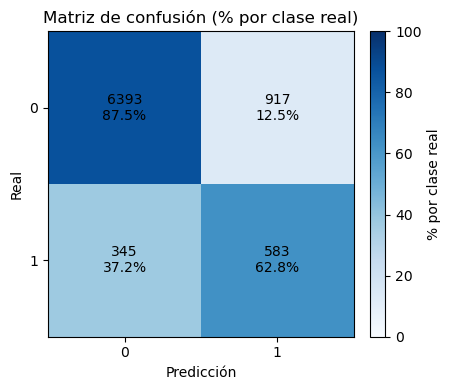

In [ ]:
# Split (y ya binaria 0/1; si no, mapear antes)
X_train = train.drop(columns=["y"])
y_train = train["y"].astype(int)
X_test  = test.drop(columns=["y"])
y_test  = test["y"].astype(int)

num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","category"]).columns.tolist()

pre = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
], remainder="drop")

clf = HistGradientBoostingClassifier(
    max_iter=300, 
    learning_rate=0.06, 
    min_samples_leaf=20, 
    random_state=42
)

pipe = Pipeline([("pre", pre), ("clf", clf)])

# Compensar desbalance SIN imputar (vía sample_weight)
w = compute_sample_weight(class_weight="balanced", y=y_train)

pipe.fit(X_train, y_train, clf__sample_weight=w)

# =========================
# Probabilidades, y_true, y_pred
# =========================
y_true = y_test
y_prob = pipe.predict_proba(X_test)[:, 1]

threshold = 0.5  # ajusta según tu objetivo (precision/recall)
y_pred = (y_prob >= threshold).astype(int)

# =========================
# Métricas
# =========================
pr_auc  = average_precision_score(y_true, y_prob)  # AUC-PR
roc_auc = roc_auc_score(y_true, y_prob)            # AUC-ROC
print(f"AUC-PR : {pr_auc:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}\n")

print(f"=== Classification report (umbral = {threshold}) ===")
print(classification_report(y_true, y_pred, digits=3))

# =========================
# Matriz de confusión: conteos + % por fila
# =========================
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
cm_pct = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true") * 100

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_pct, cmap="Blues", vmin=0, vmax=100)
ax.set_title("Matriz de confusión (% por clase real)")
ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["0", "1"]); ax.set_yticklabels(["0", "1"])

# Anotar conteos y porcentajes
for i in range(2):
    for j in range(2):
        ax.text(j, i, f"{cm[i, j]}\n{cm_pct[i, j]:.1f}%", ha="center", va="center")

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="% por clase real")
plt.tight_layout()
plt.show()


**Insights**
- **AUC-PR = 0.4656**
En problemas desbalanceados (≈11 % de positivos) es una buena referencia.
Baseline (prevalencia) ≈ 0.11, así que el modelo multiplica por ~4 la capacidad de detectar positivos frente al azar.

- **AUC-ROC = 0.8007**
Buena capacidad de separar las clases (0.5 sería azar).
Indica que, en promedio, el modelo rankea bien a los clientes propensos a suscribirse.

- **Clase 0**: El modelo acierta el 87.5 % de los “no”, pero todavía 12.5 % de ellos generan llamadas innecesarias.
- **Clase 1**: El modelo captura el 62.8 % de los verdaderos suscriptores, pero pierde al 37.2 %, que se quedarían sin la oferta.

**Resumen**:

El modelo detecta bastante bien a los interesados, pero aún hay un alto volumen de llamadas innecesarias (alrededor del 61 % de las llamadas que el modelo recomienda serán a clientes que no se suscriben).

### 7.3 LGBM model

[LightGBM] [Info] Number of positive: 19493, number of negative: 29238
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 281
[LightGBM] [Info] Number of data points in the train set: 48731, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.400012 -> initscore=-0.405414
[LightGBM] [Info] Start training from score -0.405414
AUC-PR : 0.4825
AUC-ROC: 0.8092

=== Classification report (umbral = 0.5) ===
              precision    recall  f1-score   support

           0      0.950     0.874     0.911      7310
           1      0.393     0.641     0.487       928

    accuracy                          0.848      8238
   macro avg      0.672     0.758     0.699      8238
weighted avg      0.888     0.848     0.863      8238



c:\Users\Usuario.Sooft\anaconda3\envs\rkd\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


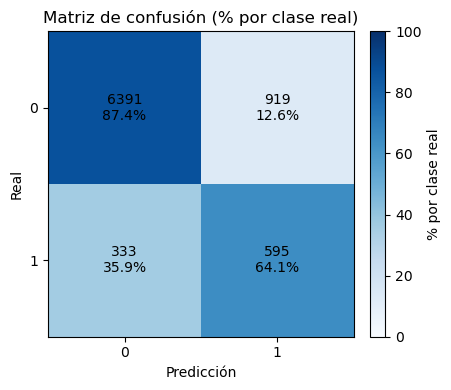

In [47]:
# =========================
# Split (y ya binaria 0/1; si no, mapear antes)
# =========================
X_train = train.drop(columns=["y"])
y_train = train["y"].astype(int)
X_test  = test.drop(columns=["y"])
y_test  = test["y"].astype(int)

# =========================
# Columnas
# =========================
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","category"]).columns.tolist()

pre = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
], remainder="drop")

# =========================
# LightGBM (maneja NaN; desbalance con scale_pos_weight)
# =========================
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos if pos > 0 else 1.0  # razón N-/N+

clf = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    scale_pos_weight=scale_pos_weight,  # compensa desbalance
    n_jobs=-1
)

pipe = Pipeline([("pre", pre), ("clf", clf)])

# =========================
# Entrenamiento con early stopping
# =========================
pipe.fit(
    X_train, y_train,
    clf__eval_set=[(X_test, y_test)],          # validación
    clf__eval_metric="auc",                    # usa AUC para early stopping
    clf__callbacks=[lgb.early_stopping(50, verbose=False)]
)

# =========================
# Probabilidades, y_true, y_pred
# =========================
y_true = y_test
y_prob = pipe.predict_proba(X_test)[:, 1]

threshold = 0.5  # ajusta según tu objetivo (precision/recall)
y_pred = (y_prob >= threshold).astype(int)

# =========================
# Métricas
# =========================
pr_auc  = average_precision_score(y_true, y_prob)  # AUC-PR
roc_auc = roc_auc_score(y_true, y_prob)            # AUC-ROC
print(f"AUC-PR : {pr_auc:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}\n")

print(f"=== Classification report (umbral = {threshold}) ===")
print(classification_report(y_true, y_pred, digits=3))

# =========================
# Matriz de confusión: conteos + % por fila
# =========================
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
cm_pct = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true") * 100

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_pct, cmap="Blues", vmin=0, vmax=100)
ax.set_title("Matriz de confusión (% por clase real)")
ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["0", "1"]); ax.set_yticklabels(["0", "1"])

for i in range(2):
    for j in range(2):
        ax.text(j, i, f"{cm[i, j]}\n{cm_pct[i, j]:.1f}%", ha="center", va="center")

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="% por clase real")
plt.tight_layout()
plt.show()


**Insights**

- Fortalezas:
    - Buen equilibrio general y mejor recall en la clase 1 que en el HistGradientBoosting previo.
    - Permite captar casi 2 de cada 3 potenciales suscriptores.
- Debilidad principal:
    - 61 % de las llamadas predichas como “sí” no se convierten, lo que puede implicar costo operativo si el contacto es caro.

**Resumen**

El modelo con LightGBM mejora ligeramente la detección de clientes que se suscriben (mejor recall y AUC-PR que el baseline anterior) manteniendo una precisión parecida. La elección del umbral final debe basarse en la relación costo de llamada / beneficio de captar un depósito.

### 7.4 XGBoost model

AUC-PR : 0.4590
AUC-ROC: 0.7826

=== Classification report (umbral = 0.5) ===
              precision    recall  f1-score   support

           0      0.945     0.878     0.910      7310
           1      0.384     0.599     0.468       928

    accuracy                          0.847      8238
   macro avg      0.665     0.739     0.689      8238
weighted avg      0.882     0.847     0.861      8238



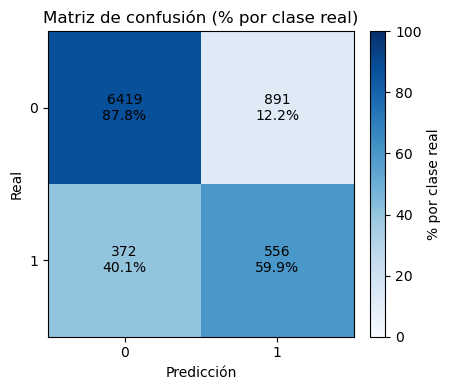

In [53]:
# =========================
# Split (y ya binaria 0/1)
# =========================
X_train = train.drop(columns=["y"])
y_train = train["y"].astype(int)
X_test  = test.drop(columns=["y"])
y_test  = test["y"].astype(int)

# =========================
# Columnas
# =========================
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object","category"]).columns.tolist()

pre = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
], remainder="drop")

# =========================
# XGBoost (sin early stopping por compatibilidad)
# =========================
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = float(neg) / float(pos) if pos > 0 else 1.0

clf = XGBClassifier(
    n_estimators=700,          # fijo (ajusta si sobre/infra-entrena)
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist",        # rápido en CPU
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",       # se usa solo para logs internos
    n_jobs=-1
)

pipe = Pipeline([("pre", pre), ("clf", clf)])

# Entrenamiento (SIN early stopping)
pipe.fit(X_train, y_train)

# =========================
# Probabilidades, y_true, y_pred
# =========================
y_true = y_test
y_prob = pipe.predict_proba(X_test)[:, 1]

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# =========================
# Métricas
# =========================
print(f"AUC-PR : {average_precision_score(y_true, y_prob):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_true, y_prob):.4f}\n")

print(f"=== Classification report (umbral = {threshold}) ===")
print(classification_report(y_true, y_pred, digits=3))

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
cm_pct = confusion_matrix(y_true, y_pred, labels=[0, 1], normalize="true") * 100

fig, ax = plt.subplots(figsize=(5, 4))
im = ax.imshow(cm_pct, cmap="Blues", vmin=0, vmax=100)
ax.set_title("Matriz de confusión (% por clase real)")
ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
ax.set_xticks([0, 1]); ax.set_yticks([0, 1])
ax.set_xticklabels(["0", "1"]); ax.set_yticklabels(["0", "1"])
for i in range(2):
    for j in range(2):
        ax.text(j, i, f"{cm[i, j]}\n{cm_pct[i, j]:.1f}%", ha="center", va="center")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="% por clase real")
plt.tight_layout(); plt.show()


**Insights**
- AUC-PR 0.46: unas 4 veces mejor que el baseline de prevalencia (~0.11).
- AUC-ROC 0.78: menor que el LightGBM anterior (~0.81), indicando algo menos de poder discriminante.
- Accuracy 0.85: alta, pero sigue dominada por la clase negativa.
- El modelo mantiene buena capacidad para filtrar no-suscriptores, pero capta menos clientes interesados que LightGBM.
- Si el objetivo es maximizar la captación (recall alto), LightGBM sigue siendo mejor.
- Si el costo de llamadas es alto, la diferencia de falsos positivos es pequeña, por lo que no ofrece ventaja clara.

En resumen: LightGBM ofrece el mejor retorno esperado, con HistGradientBoosting muy cerca y XGBoost en tercer lugar para este caso.

### Conclusiones

- LightGBM es el modelo más conveniente para el negocio.

- Capta el mayor número de clientes interesados (mayor recall y AUC-PR),

- Mantiene la misma precisión que las otras opciones, por lo que no incrementa el costo de llamadas innecesarias.

- Además, es rápido de entrenar y admite ajustes finos de hiperparámetros.

### Posibles mejoras

- Ajustar el umbral de probabilidad según el costo/beneficio de las llamadas (por ejemplo 0.4 si se prioriza recall, o 0.55 si se busca más precisión).
- Continuar con el análisis de features para sumar variables derivadas de las existentes.
- Prueba de otros modelos como CatBoost o incluso aplicar ajuste por hiperparámetros, para intentar obtener mejoras.
- Análisis de feature importances para tratar de reducir la cantidad de variables que están tomando los modelos.
- Comparar las métricas de train y de test para verificar que no haya overfitting (altas en train, pero más bajas en test).
- Probar si los modelos mejoran usando técnicas de reducción de dimensionalidad, como PCA. Para reducir la cantidad de variables que toma el modelo.
- Análisis de interpretabilidad de modelos con librerías como SHAP, ésto nos permite analizar las predicciones individuales. 
